<strong><b>Analysing MLB Home Field Advantage</b></strong>

Stephen Meyer

<b>Introduction</b>

Conventional wisdom states that baseball teams have an advantage playing in their own park.  But is this true?  How pronounced is this affect if it's real, and is it uniform across all teams, or is it more powerful for some compared to others?  Can a baseball club do anything within the organization to improve this advantage? These are all important questions managers--people who are payed to win games--must consider in order to maximize their team's chances of success.  Further, one of the best ways to get answers to these questions is through data science and analysis.


<b>Getting Started</b>

In order to get started, you'll need to download and import the following python libraries.  It would also be useful to use anaconda to manage these components (https://anaconda.org/).

In [389]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import requests
import re
from sklearn import cross_validation
import sklearn.metrics
import warnings
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.formula.api as sm
%matplotlib inline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 50

<b>Loading and Tidying Our Data</b>

First, we need to source the data relevant to our investigation, which would include things like the overall team win percentage for each team per year, home winning percentage, and location.  Unfortunately, the Lahmen baseball datasets (read about them here: http://www.seanlahman.com/baseball-archive/statistics) do not include some of the information we need like home winning percentage in their "Teams" table.  In order to get the appropriate data, we'll neeed to grab multiple CSVs from another site, baseball-reference (https://www.baseball-reference.com), and transform them to yield a table with the appropriate attributes that we can analyse. To make working with the raw CSVs easier, we'll first convert them to pandas dataframes. 

In [390]:
#load win loss tables into dataframes and drop empty rows and columns we don't need
home_wins = pd.read_csv('home_wins.csv')
team_wins = pd.read_csv('team_wins.csv')
home_wins = home_wins.dropna()
team_wins = team_wins.dropna()
home_wins = home_wins.drop(axis=1, labels=['Rk', '#Matching', 'Unnamed: 6', 'AB', 'IBB', 'HBP', 'GDP', 'SB', 'WPA', 'PA', 'SH', 'SF',
                                              '2B', '3B', 'CS'])
team_wins = team_wins.drop(axis=1, labels=['Rk', '#Matching', 'Unnamed: 6', 'AB', 'IBB', 'HBP', 'GDP', 'SB', 'WPA', 'PA', 'SH', 'SF',
                                              '2B', '3B', 'CS'])
home_wins.head()

,Tm,Year,W,L,R,H,HR,RBI,BB,SO,BA,OBP,SLG,OPS
0,TBR,2015.0,42.0,42.0,315.0,669.0,82.0,296.0,214.0,694.0,0.245,0.309,0.394,0.703
1,STL,1991.0,52.0,32.0,345.0,682.0,32.0,313.0,290.0,394.0,0.252,0.325,0.355,0.680
2,SEA,2011.0,39.0,45.0,265.0,599.0,57.0,258.0,245.0,706.0,0.222,0.289,0.333,0.623
3,PIT,1991.0,52.0,32.0,382.0,697.0,61.0,359.0,304.0,445.0,0.258,0.334,0.394,0.728
4,PHI,2010.0,54.0,30.0,410.0,747.0,94.0,397.0,282.0,495.0,0.264,0.334,0.429,0.763


<b>Taking Aggregates</b>

The home_wins dataframe represents home wins and losses for each team per year going back to 1980, while  teams_wins represents win-loss records for teams accross all games that regular season. The CSVs were yieled through querys to the site's Play Index database.  Since baseball-reference doesn't track home win percentage explicitly, we'll have to transform these tables a bit first. Let's start by calculating win percentage values for both tables and joining them.

In [391]:
#Calculate percentages and merge on team name and year
home_wins['home_win_percentage'] = home_wins.apply(lambda row: row['W'] / (row['W'] + row['L']), axis=1)
team_wins['team_win_percentage'] = team_wins.apply(lambda row: row['W'] / (row['W'] + row['L']), axis=1)
#We'll drop some unnessary columns
home_wins = home_wins.drop(axis=1, labels=['W', 'L'])
team_wins = team_wins.drop(axis=1, labels=['W', 'L'])
combined_table = pd.merge(home_wins, team_wins,  how='inner', on=['Year','Tm'])
combined_table.head()

,Tm,Year,R_x,H_x,HR_x,RBI_x,BB_x,SO_x,BA_x,OBP_x,SLG_x,OPS_x,home_win_percentage,R_y,H_y,HR_y,RBI_y,BB_y,SO_y,BA_y,OBP_y,SLG_y,OPS_y,team_win_percentage
0,TBR,2015.0,315.0,669.0,82.0,296.0,214.0,694.0,0.245,0.309,0.394,0.703,0.500000,644.0,1383.0,167.0,612.0,436.0,1310.0,0.252,0.314,0.406,0.720,0.493827
1,STL,1991.0,345.0,682.0,32.0,313.0,290.0,394.0,0.252,0.325,0.355,0.680,0.619048,651.0,1366.0,68.0,599.0,532.0,857.0,0.255,0.322,0.357,0.679,0.518519
2,SEA,2011.0,265.0,599.0,57.0,258.0,245.0,706.0,0.222,0.289,0.333,0.623,0.464286,556.0,1263.0,109.0,534.0,435.0,1280.0,0.233,0.292,0.348,0.640,0.413580
3,PIT,1991.0,382.0,697.0,61.0,359.0,304.0,445.0,0.258,0.334,0.394,0.728,0.619048,768.0,1433.0,126.0,725.0,620.0,901.0,0.263,0.338,0.398,0.737,0.604938
4,PHI,2010.0,410.0,747.0,94.0,397.0,282.0,495.0,0.264,0.334,0.429,0.763,0.642857,772.0,1451.0,166.0,736.0,560.0,1064.0,0.260,0.332,0.413,0.745,0.598765


In order to clearly visualize the data and analyse trends, we should be able to express the advantage a team has when playing in their home park through a single number.  The most natural way to calculate this number would be the difference between the win percentage at home vs the percentage in general.  We'll now take this number, multiply it by 100, and assign it as the value 'home_adv' in our table.  We'll also include a similar stat for 'ops_adv', which is considered one of the most important offensive stats in baseball https://en.wikipedia.org/wiki/On-base_plus_slugging

In [392]:
combined_table['home_adv'] = combined_table.apply(lambda row: (row['home_win_percentage'] -
                                                               row['team_win_percentage'])*100, axis=1)
combined_table['ops_adv'] = combined_table.apply(lambda row: (row['OPS_x'] - row['OPS_y'])*100, axis=1)
combined_table.head()

,Tm,Year,R_x,H_x,HR_x,RBI_x,BB_x,SO_x,BA_x,OBP_x,SLG_x,OPS_x,home_win_percentage,R_y,H_y,HR_y,RBI_y,BB_y,SO_y,BA_y,OBP_y,SLG_y,OPS_y,team_win_percentage,home_adv,ops_adv
0,TBR,2015.0,315.0,669.0,82.0,296.0,214.0,694.0,0.245,0.309,0.394,0.703,0.500000,644.0,1383.0,167.0,612.0,436.0,1310.0,0.252,0.314,0.406,0.720,0.493827,0.617284,-1.7
1,STL,1991.0,345.0,682.0,32.0,313.0,290.0,394.0,0.252,0.325,0.355,0.680,0.619048,651.0,1366.0,68.0,599.0,532.0,857.0,0.255,0.322,0.357,0.679,0.518519,10.052910,0.1
2,SEA,2011.0,265.0,599.0,57.0,258.0,245.0,706.0,0.222,0.289,0.333,0.623,0.464286,556.0,1263.0,109.0,534.0,435.0,1280.0,0.233,0.292,0.348,0.640,0.413580,5.070547,-1.7
3,PIT,1991.0,382.0,697.0,61.0,359.0,304.0,445.0,0.258,0.334,0.394,0.728,0.619048,768.0,1433.0,126.0,725.0,620.0,901.0,0.263,0.338,0.398,0.737,0.604938,1.410935,-0.9
4,PHI,2010.0,410.0,747.0,94.0,397.0,282.0,495.0,0.264,0.334,0.429,0.763,0.642857,772.0,1451.0,166.0,736.0,560.0,1064.0,0.260,0.332,0.413,0.745,0.598765,4.409171,1.8


Now, we can start plotting our data.  We'll begin just by looking at the home_adv across all teams to see if there are any obvious trends or outliers

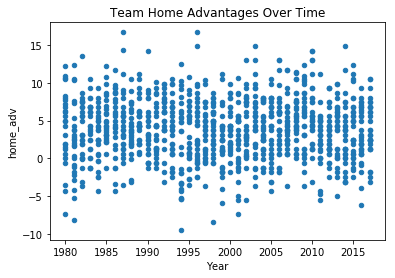

In [393]:
combined_table.plot(x='Year', y='home_adv', kind='scatter', 
                    title = 'Team Home Advantages Over Time')

As one would guess, we can see that most teams across the time frame had a positive home_adv, but it's hard to make out distributions and densities from the scatter plot alone.  Let's try using a violin plot with seaborn (https://seaborn.pydata.org/generated/seaborn.violinplot.html), looking at just 5 year increments.

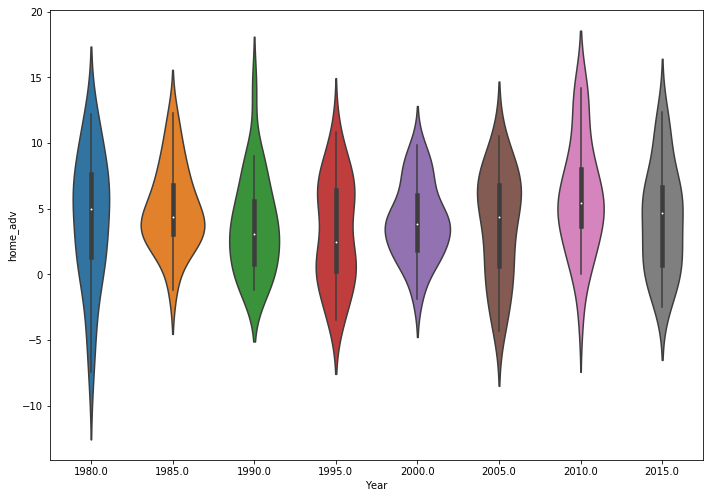

In [394]:
#ggplot(aes(x='Year', y='home_adv'), data=combined_table) +\
#    geom_violin() +\
#    labs(title="Home Field Advantage of MLB teams over time",
#         x = "Year",
#         y = "Home Advantage")
increments = ['1980', '1985', '1990', '1995', '2000', '2005', '2010', '2015']
table_five_years = combined_table.loc[combined_table['Year'].isin(increments)]
table_five_years
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.violinplot(ax=ax, x=table_five_years['Year'], y=table_five_years['home_adv'])

The violin plot more clearly shows the distribution of values for each year by displaying the density of each by the width of the "violin" at that point.  We can see that, aside from 1995, most years show unimodal distribution between the 3 and 7 home advantage values.  Moreover, year does not seem to have a clear statistical effect on home advantage based on the information we have so far.  To get a clearer sense of what's going on, let's do a few more transformations on our tables

Let's make two more tables,  one showing the average home advantage over all mlb for each year, and one showing the average across all years for each team.  We can do this using groupby and mean aggregate functions.

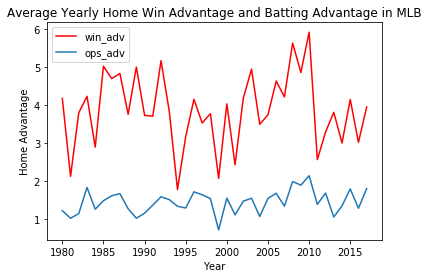

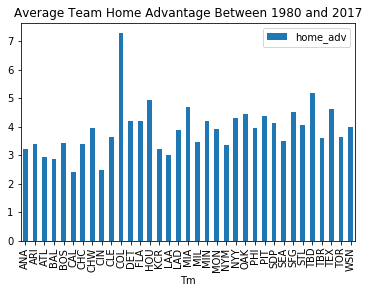

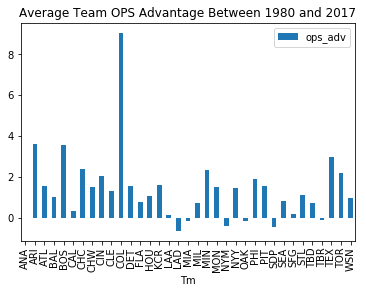

In [395]:
#averages for each year across mlb
mlb_avg = combined_table.groupby(['Year'], as_index=False)['home_adv'].mean()
mlb_ops = combined_table.groupby(['Year'], as_index=False)['ops_adv'].mean()
mlb_avg = mlb_avg.merge(right=mlb_ops, on='Year')
#averages for each team across all years
team_avg = combined_table.groupby(['Tm'], as_index=False)['home_adv'].mean()
team_ops = combined_table.groupby(['Tm'], as_index=False)['ops_adv'].mean()
team_avg = team_avg.merge(right=team_ops, on='Tm')

#plot line graphs for years and bar charts for teams
plt.plot(mlb_avg['Year'], mlb_avg['home_adv'], 'r-', label='win_adv')
plt.plot(mlb_avg['Year'], mlb_avg['ops_adv'], label='ops_adv')
plt.xlabel('Year')
plt.ylabel('Home Advantage')
plt.title('Average Yearly Home Win Advantage and Batting Advantage in MLB')
plt.legend()
plt.show()
team_avg.plot(x='Tm', y='home_adv', kind='bar', title='Average Team Home Advantage Between 1980 and 2017')
team_avg.plot(x='Tm', y='ops_adv', kind='bar', title='Average Team OPS Advantage Between 1980 and 2017')

<b>Analysing plots / Considering Variables Affecting Home Advantage</b>

The two plots allow us to make a few obervations.  First, we see that from year to year there is a lot of variation in MLB average home advantage.  This suggests that time doesn't play a significant role in determing or predicting home advantage across the major league.

Second, we can see at a glance from the bar chart which teams seem to benefit the most from playing in their home park.  With Colorado, Houston, and Tamba Bay taking the top 3 spots in terms of win advantage.  We also see that despite the home advantage strongly correlating with improved chances of winning, the home affect on the important offensive stat, ops, is much less pronounced except in the case of the Colorado Rockies.

From here, we can start investigating why certain teams seem to have more distinct home advantages compared to others.  Intuitively, we should be able to measure what affects home advantage more easily than what affects a teams overall performance.  This is because while teams cycle through players of varying quality each year, the difference in conditions between home games and away games remains relatively constant except for a few factors.  Looking at the difference between Colorado and the rest of the league's home advantage scores hints at one possible avenue of investigation.  That is, the affects of location and climate on home advantage.

The Colorado Rockies are known for having a unique home field, in that it sits at the highest elevation of any major league ballpark.  This means that the atmosphere at the park is thinner, and that balls tend travel farther off the bat as a result (read more on this here https://en.wikipedia.org/wiki/Coors_Field#Reputation_as_a_home_run-friendly_park).  This is evidenced by the high OPS advantage indicated for Colorado in our data.  However, although you would expect both the home and away teams to benefit equally from this condition, the Rockies still tend to fair much better at home in terms of wins and losses.  This could suggest that playing, practicing, and conditioning on the same field provides tangible benefits to a team's success at that field, but does this hold true for parks in environments that aren't as unique as Coor's Field?

To explore this, lets gather some location data for each team and include it in our table of team averages.

In [396]:
#associate team with park coordinates.  Modified a json file with coordinates
# from https://gist.github.com/the55/2155142 by changing team names
# to codes in dataframe and adding teams that no longer exist but are
#listed in original datafram.  Very tedious.
locations = pd.read_json('locations.json')
locations = locations.append({'team':'MIA', "lat": 25.954428, "lng":-80.238164}, ignore_index=True)
locations = locations.append({'team':'CAL', "lat": 33.799572, "lng":-117.889031}, ignore_index=True)
#change column names to facilitate join
locations.columns = ['lat', 'lng', 'Tm']
team_avg = team_avg.merge(right=locations, on='Tm')
team_avg.head()

,Tm,home_adv,ops_adv,lat,lng
0,ANA,3.223803,-0.025000,33.799572,-117.889031
1,ARI,3.395062,3.640000,33.452922,-112.038669
2,ATL,2.924131,1.539474,33.746910,-84.391239
3,BAL,2.871430,1.005263,39.285243,-76.620103
4,BOS,3.436248,3.550000,42.346613,-71.098817


<b>Mapping Data Spatially</b>

We can now try building a folium map using these coordinates and visualizing the team home advantage with the size of our markers. If you're unfamilliar with folium maps you can read up on them here https://folium.readthedocs.io/en/latest/

In [397]:
#generate map with radius based on home advantage
#and color blue if team is in top 10, red if team
#is in bottom 10, and green for everyone else

map_osm = folium.Map(location=[40, -90], zoom_start=3)

color_rank = '#009900'
for index, row in team_avg.iterrows():
    color_rank = '#009900'
    if (row.home_adv > 4.2): 
        color_rank='#3333cc'
    elif (row.home_adv < 3.43): 
        color_rank = '#cc0000'
    folium.CircleMarker(radius=(row.home_adv*3),
                        location=[row.lat, row.lng], 
                        fill=True,
                        color=color_rank,
                        fill_color=color_rank,
                        popup=row.Tm + '     ' + str(row.home_adv)).add_to(map_osm)

map_osm

We can see from the map that, although climate is obviously a factor for Colorado's home advantage, it's hard to pick out any affect location has on home advantage for the other teams marked. We can note a few things, like that both Oakland and San Francisco have almost idenitical home advantages while also being in about the same location.  Additionally, it appears the northernmost teams aside from the Cubs and Mets have the most consistently average home advantage, whereas teams in other regions tend to vary more widely.  While some of the teams with the highest home advantage aside from Colorado occupy warmer parts of the country, other warm weather teams like Arizona and Atlanta also have some of the worst.

We'll have to look at other factors that might contribute to home advantage before we conclude.  One possible avenue to explore would be attendance.  In many sports, the energy of the crowd is considered a positive force on the performance of players, and one would expect higher attendance levels would magnify this affect.  To analyse this, we'll need to grab some attendance data from Sean Lahmen's baseball data sets. The data will have to be modified a bit so that the team codes in Lahmens CSV match the ones from our original table.  This will have to be done manually for each offending code

In [398]:
team_attendance = pd.read_csv('Teams.csv')
team_attendance = team_attendance[team_attendance.yearID>1980]
team_attendance = team_attendance[['yearID', 'teamID', 'attendance']]
team_attendance.columns = ['Year', 'Tm', "attendance"]
#convert bad codes
team_attendance=team_attendance.replace('CHA', 'CHW')
team_attendance=team_attendance.replace('CHN', 'CHC')
team_attendance=team_attendance.replace('FLO', 'FLA')
team_attendance=team_attendance.replace('KCA', 'KCR')
team_attendance=team_attendance.replace('NYA', 'NYY')
team_attendance=team_attendance.replace('NYN', 'NYM')
team_attendance=team_attendance.replace('SDN', 'SDP')
team_attendance=team_attendance.replace('TBA', 'TBR')
team_attendance=team_attendance.replace('SLN', 'STL')
team_attendance=team_attendance.replace('SFN', 'SFG')
team_attendance=team_attendance.replace('ML4', 'TBD')
team_attendance=team_attendance.replace('LAN', 'LAD')
team_attendance=team_attendance.replace('WAS', 'WSN')
#get average attendance with groupby and mean()
avg_attendance = team_attendance.groupby(['Tm'], as_index=False)['attendance'].mean()
team_avg_attend = team_avg.merge(right=avg_attendance, on='Tm')
team_avg_attend.head()

,Tm,home_adv,ops_adv,lat,lng,attendance
0,ANA,3.223803,-0.025000,33.799572,-117.889031,2.418744e+06
1,ARI,3.395062,3.640000,33.452922,-112.038669,2.453297e+06
2,ATL,2.924131,1.539474,33.746910,-84.391239,2.291857e+06
3,BAL,2.871430,1.005263,39.285243,-76.620103,2.474774e+06
4,BOS,3.436248,3.550000,42.346613,-71.098817,2.496453e+06


Now, lets make a double bar chart with our new attendance parameter.

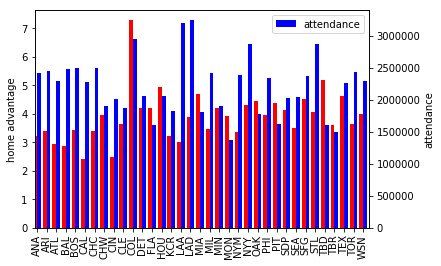

In [399]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax2 = ax.twinx()

width = 0.4

team_avg_attend.home_adv.plot(kind='bar', color='red', ax=ax, width=width, position=1)
team_avg_attend.attendance.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

team_names = ['ANA','ARI','ATL','BAL','BOS','CAL','CHC','CHW','CIN','CLE','COL','DET','FLA','HOU','KCR','LAA','LAD','MIA','MIL','MIN','MON','NYM','NYY','OAK','PHI','PIT','SDP','SEA','SFG','STL','TBD','TBR','TEX','TOR','WSN']
y_pos = np.arange(len(team_names))
ax2.set_ylabel('attendance')
ax.set_ylabel('home advantage')
plt.xticks(y_pos, team_names)
plt.legend()
plt.show()

We can also track home advantage and attendance over time for a few select teams.  Let's pick the Rockies, the Yankees, the Braves, and the Cardinals.

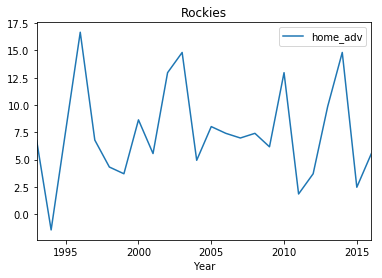

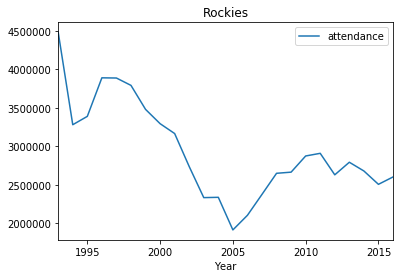

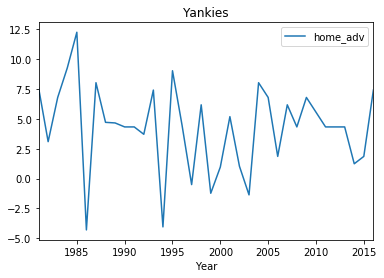

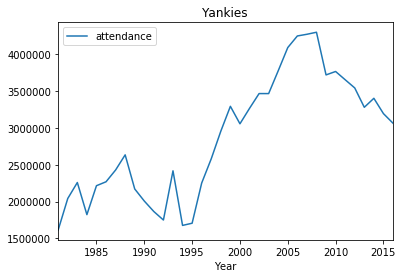

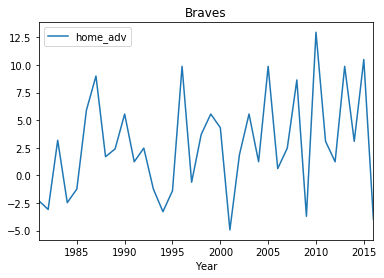

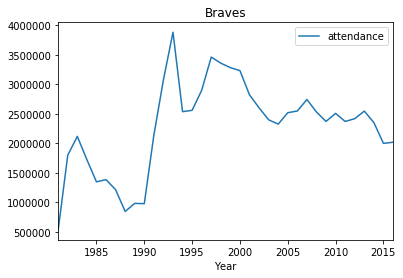

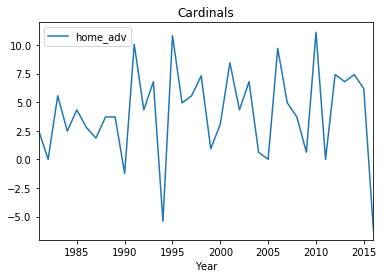

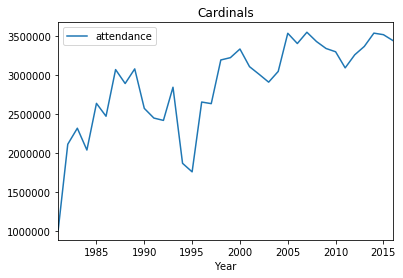

In [400]:
roc = combined_table[combined_table.Tm == 'COL'].merge(right=team_attendance[team_attendance.Tm =='COL'], on='Year')
yank = combined_table[combined_table.Tm == 'NYY'].merge(right=team_attendance[team_attendance.Tm =='NYY'], on='Year')
brav = combined_table[combined_table.Tm == 'ATL'].merge(right=team_attendance[team_attendance.Tm =='ATL'], on='Year')
card = combined_table[combined_table.Tm == 'STL'].merge(right=team_attendance[team_attendance.Tm =='STL'], on='Year')
roc = roc.sort_values('Year')
yank = yank.sort_values('Year')
brav = brav.sort_values('Year')
card = card.sort_values('Year')

roc.plot('Year', 'home_adv', title='Rockies')
roc.plot('Year', 'attendance', title='Rockies')

yank.plot('Year', 'home_adv', title='Yankies')
yank.plot('Year', 'attendance', title='Yankies')

brav.plot('Year', 'home_adv', title='Braves')
brav.plot('Year', 'attendance', title='Braves')

card.plot('Year', 'home_adv', title='Cardinals')
card.plot('Year', 'attendance', title='Cardinals')
#yearly_attendance = 

The relationship between attenandance and home advantage is unclear, though we can get a more accurate assessment by doing some basic statistical analysis.  Pandas has a function called corr() that returns the correlation between two columns in a dataframe, with 1 being total positive correlation and 0 being no correlation.  You can read about the corr function here: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html

In [401]:
team_corr = team_avg_attend['home_adv'].corr(team_avg_attend['attendance'])
print("All teams: " + str(team_corr))
roc_corr = roc['home_adv'].corr(roc['attendance'])
print('Rockies' + str(roc_corr))
yank_corr = yank['home_adv'].corr(yank['attendance'])
print('Yankies: '+str(yank_corr))
brav_corr = brav['home_adv'].corr(brav['attendance'])
print('Braves: ' +str(brav_corr))
card_corr = card['home_adv'].corr(card['attendance'])
print('Cardinals: ' + str(card_corr))

All teams: -0.0263659025329
Rockies-0.0468806649673
Yankies: -0.0704945755176
Braves: 0.0392997125375
Cardinals: 0.100039071841


As we can see from the correlation values, the attendance total for MLB teams does little to predict their win advantage at both the macro and individual level.

<b>Conclusion</b>

With this tutorial, we have seen how to gather data from different sources, tidy it, and transform it into more useful forms through joins and cuts.  We have used python to collect aggregates like means over both quantitative and categorical variables.  We have displayed our data in various forms of plots and spatial maps to provide insights to the investigation, and used these insights to idenitfy possible sources of statistical correlation.

Through the data analysis, we discoved that while home field advantage is a tangible factor in determining MLB wins and losses, the sources of this advantage are not evident from obvious factors like location and crowd size, aside from a few outliers like Colorado. In order for Major League front offices to maximize their own team's homefield advantage, they would have to look deeper at more organizational factors that are harder to quantify like training and team facilities.

It may also be interesting to do this analyises with other sports like American Footbal, where the Winter season and the fact that games are played through rain make local conditions a more pronounced factor.

<b>References</b>

Anaconda: https://anaconda.org/

Attendance Data: http://www.seanlahman.com/baseball-archive/statistics

Team Coordinates: https://gist.github.com/the55/2155142

All other data: https://www.baseball-reference.com

Folium: https://folium.readthedocs.io/en/latest/

Pandas: http://pandas.pydata.org

matplotlib plots: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html

Seaborn plots: https://seaborn.pydata.org/generated/seaborn.violinplot.html
